In [1]:
# df_corr = vip_df[['요구불예금잔액', '거치식예금잔액', '적립식예금잔액', '수익증권잔액', '신탁잔액',
#        '퇴직연금잔액', '여신한도금액', '여신_운전자금대출잔액', '여신_시설자금대출잔액', '외환_수출실적금액',
#        '외환_수입실적금액', '신용카드사용금액', '체크카드사용금액', '창구거래금액', '인터넷뱅킹거래금액', '스마트뱅킹거래금액',
#        '폰뱅킹거래금액', 'ATM거래금액', '자동이체금액', '요구불입금금액', '요구불출금금액', '총카드사용액', '총예금잔액',
#        '총여신잔액', '총투자잔액', '총거래금액', '대출예금잔액', '법인_고객등급', '전담고객여부', '요구불예금좌수',
#        '거치식예금좌수', '적립식예금좌수', '수익증권좌수', '신탁좌수', '퇴직연금좌수', '여신_운전자금대출좌수',
#        '여신_시설자금대출좌수', '신용카드개수', '외환_수출실적거래건수', '외환_수입실적거래건수', '창구거래건수',
#        '인터넷뱅킹거래건수', '스마트뱅킹거래건수', '폰뱅킹거래건수', 'ATM거래건수', '자동이체거래건수', '외부_여신시설자금',
#        '외부_여신운전자금', '교차판매지수', '상품다양성지수', '총거래건수', 'LTV_Score', '거래감소율', '대출비중',
#        'LTV_Score_norm', '대출비중_norm', '거래감소율_norm', '상품다양성지수_norm', '리스크스코어',
#        '이탈여부']].corr()
# print(df_corr)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# -----------------------------
# 데이터 로드 & 컬럼 정리
# -----------------------------
vip_df = pd.read_csv("C:\\Users\\seomi\\바탕 화면\\iM Digital academy\\data\\vip_final.csv")
vip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16596 entries, 0 to 16595
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   기준년월            16596 non-null  int64  
 1   세그먼트ID          16596 non-null  object 
 2   요구불예금잔액         16596 non-null  float64
 3   거치식예금잔액         16596 non-null  float64
 4   적립식예금잔액         16596 non-null  float64
 5   수익증권잔액          16596 non-null  float64
 6   신탁잔액            16596 non-null  float64
 7   퇴직연금잔액          16596 non-null  float64
 8   여신한도금액          16596 non-null  float64
 9   여신_운전자금대출잔액     16596 non-null  float64
 10  여신_시설자금대출잔액     16596 non-null  float64
 11  외환_수출실적금액       16596 non-null  float64
 12  외환_수입실적금액       16596 non-null  float64
 13  신용카드사용금액        16596 non-null  float64
 14  체크카드사용금액        16596 non-null  float64
 15  창구거래금액          16596 non-null  float64
 16  인터넷뱅킹거래금액       16596 non-null  float64
 17  스마트뱅킹거래금액       16596 non-null 

In [3]:
# 핵심 피처 리스트
base_features = [
    '총거래금액', 
    '총거래건수', 
    '총예금잔액', 
    '총여신잔액', 
    '대출비중', 
    '상품다양성지수', 
    '총카드사용액', 
    '외환_수출실적금액', 
    '외환_수입실적금액',
    '외부_여신시설자금', 
    '외부_여신운전자금'
]

# 고정값 피처 (lag 불필요)
static_features = ['법인_고객등급', '전담고객여부']

In [4]:
def create_time_series_features(df, group_col, time_col, feature_cols, 
                                lag_list=[1], rolling_windows=[3]):
    """
    시계열 피처(lag, diff, rolling)를 자동으로 생성하는 함수
    ------------------------------------------
    df : pandas.DataFrame
    group_col : 그룹 기준 (세그먼트ID 등)
    time_col : 시간 기준 (기준년월 등)
    feature_cols : 시계열 피처 생성 대상 컬럼 리스트
    lag_list : 생성할 lag 시차 목록
    rolling_windows : 생성할 rolling 기간 목록
    """
    df = df.copy()
    df = df.sort_values([group_col, time_col])
    g = df.groupby(group_col)
    
    for col in feature_cols:
        # Lag features
        for lag in lag_list:
            new_col = f"{col}_lag{lag}"
            df[new_col] = g[col].shift(lag)
        
        # Diff features (현재 - lag1)
        if 1 in lag_list:
            df[f"{col}_diff1"] = df[col] - df[f"{col}_lag1"]
        
        # Rolling features
        for win in rolling_windows:
            new_col = f"{col}_roll{win}"
            df[new_col] = g[col].transform(lambda x: x.rolling(window=win, min_periods=1).mean())

    # NaN 처리 (초기 구간 등)
    df = df.fillna(0)
    return df

In [5]:
# 기준년월을 datetime으로 변환 (혹시 안 되어 있다면)
# 1) 문자열(YYYYMM) → datetime으로 변환
vip_df['기준년월'] = pd.to_datetime(vip_df['기준년월'], format='%Y%m')

# 2) datetime → period(M)으로 변환
vip_df['기준년월'] = vip_df['기준년월'].dt.to_period('M')

vip_df = vip_df.sort_values(['세그먼트ID', '기준년월'])

# 함수 적용
vip_df_ts = create_time_series_features(
    df=vip_df,
    group_col='세그먼트ID',
    time_col='기준년월',
    feature_cols=base_features,
    lag_list=[1],            # 1개월 전 값
    rolling_windows=[3]      # 최근 3개월 평균
)

print(vip_df_ts.shape)
vip_df_ts.head()


(16596, 95)


,기준년월,세그먼트ID,요구불예금잔액,거치식예금잔액,적립식예금잔액,수익증권잔액,신탁잔액,퇴직연금잔액,여신한도금액,여신_운전자금대출잔액,...,외환_수출실적금액_roll3,외환_수입실적금액_lag1,외환_수입실적금액_diff1,외환_수입실적금액_roll3,외부_여신시설자금_lag1,외부_여신시설자금_diff1,외부_여신시설자금_roll3,외부_여신운전자금_lag1,외부_여신운전자금_diff1,외부_여신운전자금_roll3
0,2022-01,건설업_전문직별 공사업_경상북도_경산시,4522.80,2672.0,125.6,0.0,2503.8,1440.8,9480.0,13320.0,...,0.0,0.0,0.00,0.00,0.000000,0.000000,172600.000000,0.0,0.000000,678400.000000
1,2022-02,건설업_전문직별 공사업_경상북도_경산시,3918.84,2673.0,142.6,0.0,2297.8,1454.8,13340.0,14983.0,...,0.0,0.0,0.00,0.00,172600.000000,3966.666667,174583.333333,678400.0,8600.000000,682700.000000
2,2022-03,건설업_전문직별 공사업_경상북도_경산시,2204.27,943.0,155.4,0.0,2319.2,1446.2,8910.0,12717.9,...,0.0,0.0,0.00,0.00,176566.666667,3966.666667,176566.666667,687000.0,8600.000000,687000.000000
3,2022-04,건설업_전문직별 공사업_경상북도_경산시,1537.49,943.0,168.2,0.0,2156.3,1453.3,8810.0,13010.0,...,0.0,0.0,0.00,0.00,180533.333333,3966.666667,180533.333333,695600.0,8600.000000,695600.000000
4,2022-05,건설업_전문직별 공사업_경상북도_경산시,3330.63,943.0,180.8,0.0,1732.5,1499.5,13410.0,15323.0,...,0.0,0.0,0.03,0.01,184500.000000,4766.666667,184766.666667,704200.0,2833.333333,702277.777778


In [6]:
# ✅ Feature 리스트 다시 구성
feature_cols = []
for col in base_features:
    feature_cols += [col, f"{col}_lag1", f"{col}_diff1", f"{col}_roll3"]
feature_cols += static_features

# ✅ Target
target_col = '이탈여부'

# ✅ X, y
X = vip_df_ts[feature_cols]
y = vip_df_ts[target_col]

print("최종 Feature 수:", len(feature_cols))
print("데이터셋 크기:", X.shape)

최종 Feature 수: 46
데이터셋 크기: (16596, 46)


In [7]:
# 시계열 교차검증 (예: 5번 분할)
tscv = TimeSeriesSplit(n_splits=5)

# 분할 예시 확인
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"[Fold {fold+1}] Train: {len(train_idx)}, Test: {len(test_idx)}")

[Fold 1] Train: 2766, Test: 2766
[Fold 2] Train: 5532, Test: 2766
[Fold 3] Train: 8298, Test: 2766
[Fold 4] Train: 11064, Test: 2766
[Fold 5] Train: 13830, Test: 2766


In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score

auc_scores = []
f1_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='auc'
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    auc_scores.append(auc)
    f1_scores.append(f1)
    print(f"[Fold {fold+1}] AUC: {auc:.4f}, F1: {f1:.4f}")

print(f"\n평균 AUC: {np.mean(auc_scores):.4f}")
print(f"평균 F1: {np.mean(f1_scores):.4f}")

[Fold 1] AUC: 0.9161, F1: 0.7309
[Fold 2] AUC: 0.9353, F1: 0.7647
[Fold 3] AUC: 0.9444, F1: 0.6963
[Fold 4] AUC: 0.9305, F1: 0.6547
[Fold 5] AUC: 0.9528, F1: 0.7500

평균 AUC: 0.9358
평균 F1: 0.7193


<Figure size 1000x600 with 0 Axes>

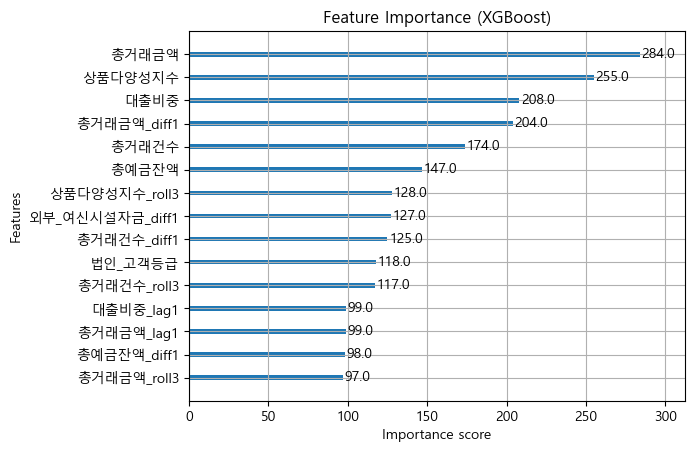

In [9]:
import matplotlib.pyplot as plt
import xgboost as xgb

plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=15)
plt.title('Feature Importance (XGBoost)')
plt.show()

In [10]:
y_pred_proba_full = model.predict_proba(X)[:, 1]
vip_df_ts['이탈확률'] = y_pred_proba_full

# 상위 20%를 High Risk로 지정
threshold = vip_df_ts['이탈확률'].quantile(0.8)
vip_df_ts['Risk_Level'] = np.where(
    vip_df_ts['이탈확률'] >= threshold, 'High',
    np.where(vip_df_ts['이탈확률'] >= vip_df_ts['이탈확률'].quantile(0.5), 'Medium', 'Low')
)

print(vip_df_ts['Risk_Level'].value_counts())


Risk_Level
Low       8298
Medium    4978
High      3320
Name: count, dtype: int64


### Shap

In [11]:
import shap

# 트리 기반 모델에 최적화된 Explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)


👉 shap_values는 각 고객(row)에 대해 각 피처가 예측값에 미친 영향을 수치화한 값

값이 클수록 이탈 예측에 더 큰 영향을 줬다는 뜻

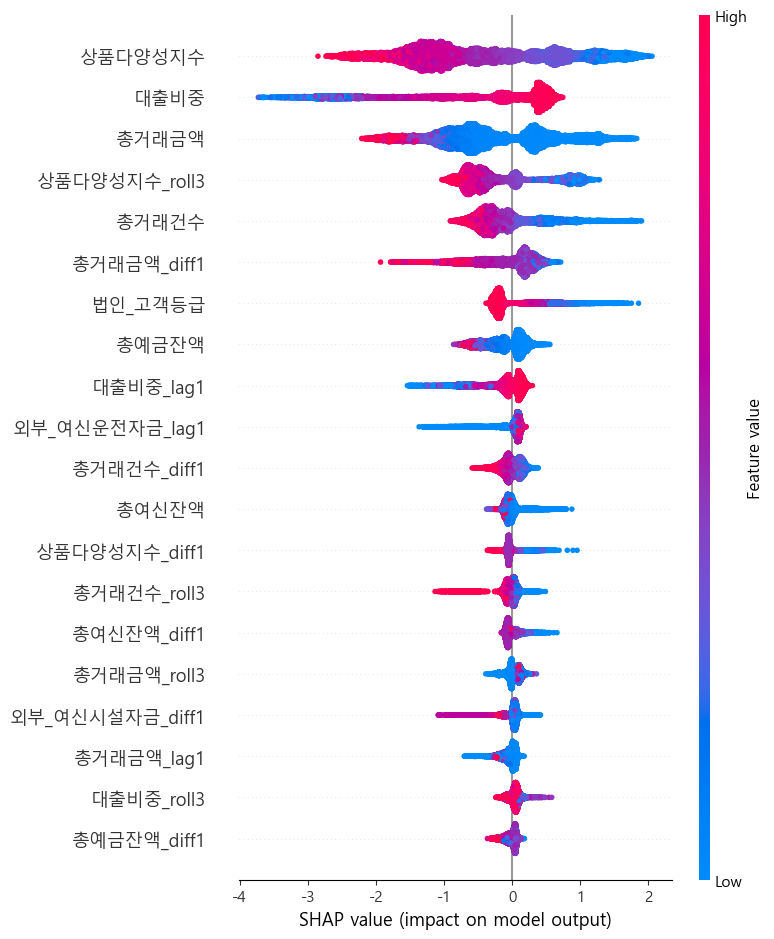

In [12]:
# 요약 플롯 (전체 피처 중요도 + 영향 방향)
shap.summary_plot(shap_values, X, plot_type="dot")

(+) : 이탈 확률을 올리는 방향으로 작용한 피처

왼쪽(–) : 이탈 확률을 낮추는 방향으로 작용한 피처

색상 : 해당 피처의 값 (빨강=높은 값, 파랑=낮은 값)

👉 예:

총거래금액_roll3가 낮으면(파랑) → 이탈 확률 ↑

상품다양성지수가 높으면(빨강) → 이탈 확률 ↓

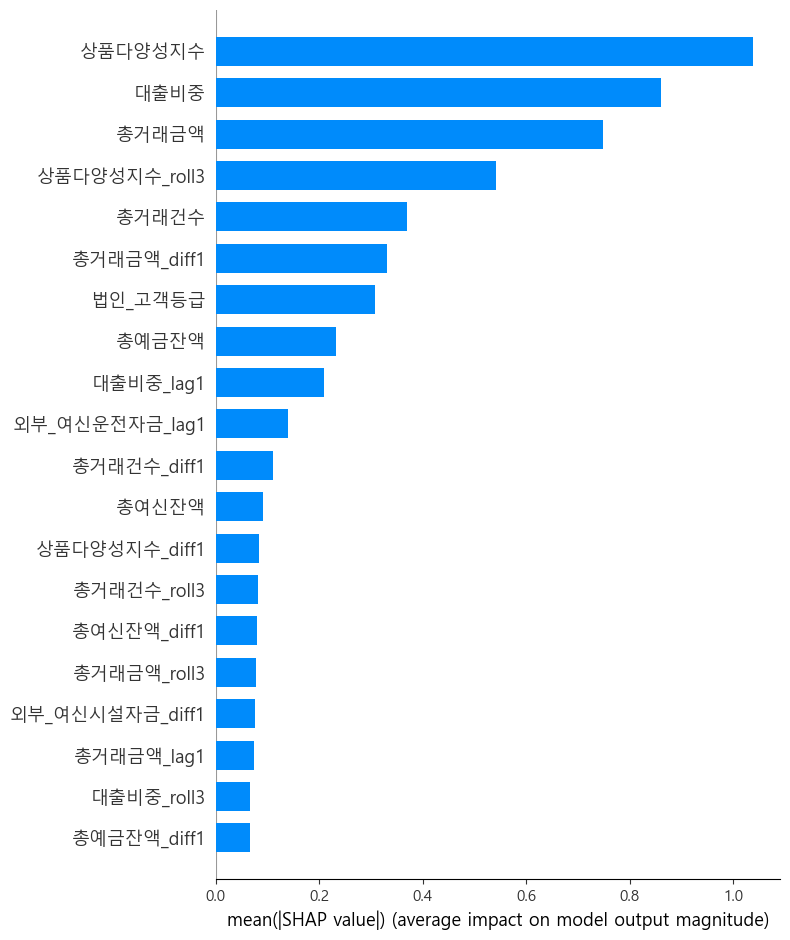

In [13]:
# 피처 영향도만 순서대로 정렬한 바 플롯
shap.summary_plot(shap_values, X, plot_type="bar")

👉 모델이 어떤 피처에 가장 많이 의존하고 있는지 확인 가능

In [14]:
# 한 고객(행)에 대한 예측 설명 (예: 인덱스 10)
i = 10
shap.force_plot(explainer.expected_value, shap_values[i,:], X.iloc[i,:])

👉 이 시각화는

어떤 피처가 이탈 확률을 끌어올렸는지(빨강)

어떤 피처가 확률을 끌어내렸는지(파랑)
를 직관적으로 보여줍니다.

💡 예:

거래금액_diff1 ↓ → 최근 거래액 급감 → 이탈 위험 ↑

상품다양성지수 ↑ → 상품 보유 다양 → 이탈 위험 ↓

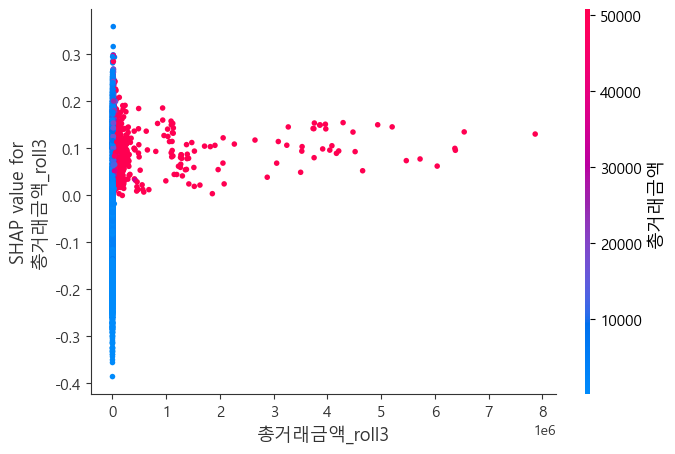

In [15]:
# 특정 피처의 값이 예측값에 어떤 영향을 미치는지
shap.dependence_plot("총거래금액_roll3", shap_values, X)

👉 이걸로 “거래금액이 어느 수준 이하일 때 이탈 위험이 급격히 높아지는지” 같은 패턴을 발견

이는 경영/마케팅 부서에 경보 기준을 제시할 때 매우 유용

### Feature Select

In [16]:
import numpy as np
import pandas as pd
import shap

# SHAP 값 다시 계산 (이미 했다면 생략 가능)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 피처별 중요도 평균 절대값 계산
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

# 상위 N개 선택
top_n = 15
top_features = importance_df['feature'].head(top_n).tolist()

print(f"SHAP Top {top_n} Features:")
print(top_features)

SHAP Top 15 Features:
['상품다양성지수', '대출비중', '총거래금액', '상품다양성지수_roll3', '총거래건수', '총거래금액_diff1', '법인_고객등급', '총예금잔액', '대출비중_lag1', '외부_여신운전자금_lag1', '총거래건수_diff1', '총여신잔액', '상품다양성지수_diff1', '총거래건수_roll3', '총여신잔액_diff1']


In [17]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, f1_score

X_top = X[top_features]
tscv = TimeSeriesSplit(n_splits=5)

auc_scores = []
f1_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_top)):
    X_train, X_test = X_top.iloc[train_idx], X_top.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model_top = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='auc'
    )
    model_top.fit(X_train, y_train)

    y_pred = model_top.predict(X_test)
    y_pred_proba = model_top.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    auc_scores.append(auc)
    f1_scores.append(f1)

    print(f"[Fold {fold+1}] AUC: {auc:.4f}, F1: {f1:.4f}")

print(f"\nTop {top_n} Features 평균 AUC: {np.mean(auc_scores):.4f}")
print(f"Top {top_n} Features 평균 F1: {np.mean(f1_scores):.4f}")

[Fold 1] AUC: 0.9163, F1: 0.7457
[Fold 2] AUC: 0.9339, F1: 0.7556
[Fold 3] AUC: 0.9458, F1: 0.6937
[Fold 4] AUC: 0.9278, F1: 0.6291
[Fold 5] AUC: 0.9517, F1: 0.7415

Top 15 Features 평균 AUC: 0.9351
Top 15 Features 평균 F1: 0.7131


In [18]:
df_export = vip_df_ts[top_features + ['이탈여부']]
df_export.to_csv('vip_final_features.csv', index=False)

Shap기반 top 105로 모델을 돌렸을 때 평균 AUC가 아주 미미하게 낮아졌기 때문에, 성능 부분에서 아주 좋다고 할 수 있다.